# **Image preprocessing**


The algorithm should be able to process an image like this:

![image_example](image_example.png)

into the MNIST-like image.

## **Step-by-step experiments**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.transforms as T

In [2]:
im = T.Grayscale()(Image.open("image_example.png"))
npim = np.array(im)
ptim = T.ToTensor()(im)
ptim[:4, :5]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [3]:
mean, std = ptim.mean(), ptim.std()
mean, std

(tensor(0.0388), tensor(0.1860))

In [4]:
ptim = T.Normalize(ptim.mean(), ptim.std())(ptim)
ptim = ptim.view(*ptim.size()[1:])
fill_val = min(ptim.flatten()).item()

In [5]:
npim.shape

(283, 587)

In [6]:
ptim[271:281, 465:475]

tensor([[ 4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,
          4.8935,  4.8935],
        [ 4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,
          4.8935,  4.8935],
        [ 4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,
          4.8935,  4.8935],
        [ 4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,
          4.8935,  4.8935],
        [ 4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.8935,  4.3453,  3.5863,
          2.7430,  0.5082],
        [ 4.8935,  4.4085,  3.6496,  2.8273,  1.8154,  0.6347,  0.0655,  0.0233,
         -0.0399, -0.1875],
        [ 0.7612,  0.0866,  0.0233, -0.0188, -0.1032, -0.1664, -0.2086, -0.2086,
         -0.2086, -0.2086],
        [-0.1664, -0.2086, -0.2086, -0.2086, -0.2086, -0.2086, -0.2086, -0.2086,
         -0.2086, -0.2086],
        [-0.2086, -0.2086, -0.2086, -0.2086, -0.2086, -0.2086, -0.2086, -0.2086,
         -0.2086, -0.2086],
        [-0.2086, -

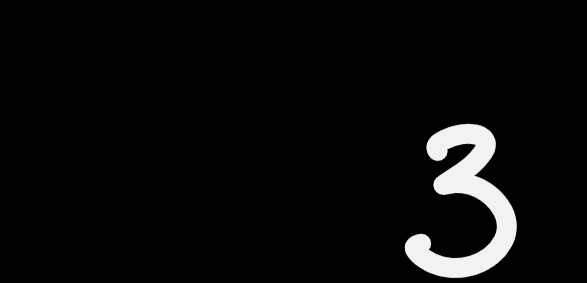

In [7]:
im

In [8]:
np.amin(np.where(npim > 0), axis=1)

array([123, 404], dtype=int64)

In [9]:
torch.amin(torch.stack(torch.where(ptim > 0)), dim=1)

tensor([123, 404])

([], [])

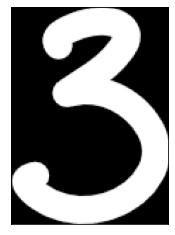

In [10]:
top, left = torch.amin(torch.stack(torch.where(ptim > 0)), dim=1)
bottom, right = torch.amax(torch.stack(torch.where(ptim > 0)), dim=1)
plt.imshow(ptim[top:bottom, left:right], cmap='gray')
plt.xticks([])
plt.yticks([])

In [11]:
center = torch.tensor([(top.item() + bottom.item()) // 2, (left.item() + right.item()) // 2])
center

tensor([200, 460])

In [12]:
imrad = max(bottom - center[0], right - center[1])
imrad

tensor(78)

In [13]:
center + imrad < torch.tensor(ptim.size())

tensor([True, True])

In [14]:
torch.tensor(ptim.size()) - (center + imrad)

tensor([ 5, 49])

([], [])

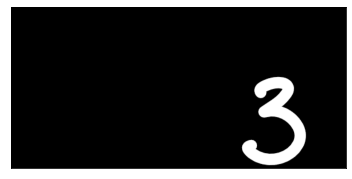

In [15]:
if sum(center + imrad < torch.tensor(ptim.size())) < 2 or sum(center - imrad > 0) < 2:
    br_offsite = abs(min(torch.tensor(ptim.size()) - (center + imrad)))
    tl_offsite = abs(min(center - imrad))
    pad = max(br_offsite, tl_offsite)
    ptim_2 = T.Pad(padding=pad.item(), fill=fill_val)(ptim)
    center += pad
else:
    ptim_2 = ptim
    
plt.imshow(ptim_2, cmap='gray')
plt.xticks([])
plt.yticks([])

In [16]:
ptim.size(), ptim_2.size()

(torch.Size([283, 587]), torch.Size([283, 587]))

In [17]:
topc, leftc = center - imrad
bottomc, rightc = center + imrad
topc, leftc

(tensor(122), tensor(382))

([], [])

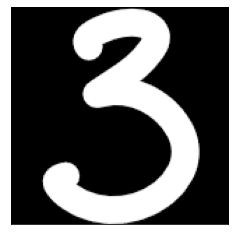

In [18]:
ptim_3 = ptim_2[topc:bottomc, leftc:rightc]
plt.imshow(ptim_3, cmap='gray')
plt.xticks([])
plt.yticks([])

([], [])

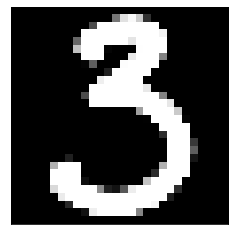

In [19]:
ptim_4 = T.Resize(size=[26, 26])(ptim_3.view(1, 1, *ptim_3.size())).view(26, 26)
ptim_4 = T.Pad(padding=1, fill=fill_val)(ptim_4)
plt.imshow(ptim_4, cmap='gray')
plt.xticks([])
plt.yticks([])

In [20]:
ptim_4.size()

torch.Size([28, 28])

## **Complete function**

In [45]:
def prepare_image(im, output_size=28):
    """Prepares an image for training
    
    Parameters
    ----------
        im : PIL image
            An input image.
        output_size : integer, optional
            The size of the output image. Default 28.
    """
    # Convert to grayscale PyTorch Tensor
    ptim = T.ToTensor()(T.Grayscale()(im))
    ptim = ptim.view(*ptim.size()[1:])
    back_val = min(ptim.flatten()).item()
      
    # Find the digit in the image
    top, left = torch.amin(torch.stack(
        torch.where(ptim > back_val)), dim=1)
    bottom, right = torch.amax(torch.stack(
        torch.where(ptim > back_val)), dim=1)
    center = torch.tensor([
        (top.item() + bottom.item()) // 2, 
        (left.item() + right.item()) // 2,
    ])
    imrad = max(bottom - center[0], right - center[1])
    
    # Make a padding if the (center + radius) is biger 
    # then an input image or (center - radius) < 0.
    if (sum(center + imrad < torch.tensor(ptim.size())) < 2 
        or sum(center - imrad > 0) < 2):
        
        br_offsite = abs(min(torch.tensor(ptim.size()) - (center + imrad)))
        tl_offsite = abs(min(center - imrad))
        pad = max(br_offsite, tl_offsite)
        ptim = T.Pad(padding=pad.item(), fill=back_val)(ptim)
        center += pad
    
    # Crop, resize and normalize the image
    topc, leftc = center - imrad
    bottomc, rightc = center + imrad
    ptim = ptim[topc:bottomc, leftc:rightc]
    ptim = ptim.view(1, 1, *ptim.size())
    ptim = T.Resize(size=[output_size-4, output_size-4])(ptim)
    ptim = T.Pad(padding=2, fill=back_val)(ptim)
    mean, std = ptim.mean(), ptim.std()
    ptim = T.Normalize(mean, std)(ptim)
    
    return ptim
    

## **Exhibition**

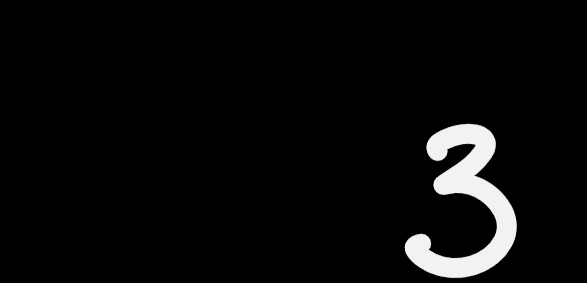

In [46]:
im1 = Image.open("image_example.png")
im1

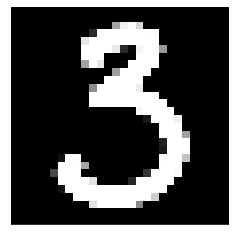

In [47]:
plt.imshow(prepare_image(im1)[0][0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

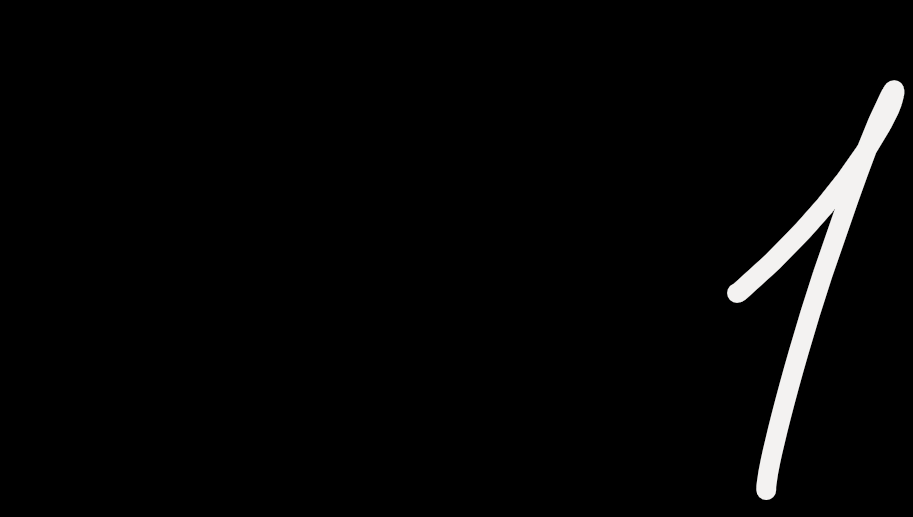

In [48]:
im2 = Image.open("image_example_v2.png")
im2

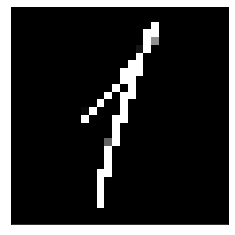

In [49]:
plt.imshow(prepare_image(im2)[0][0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

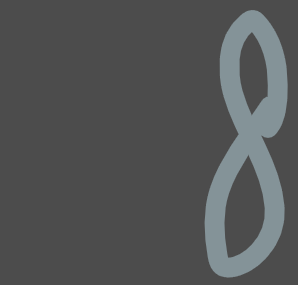

In [50]:
im3 = Image.open("image_example_v3.png")
im3

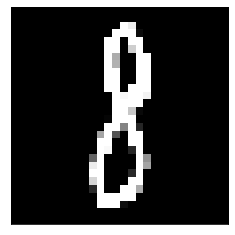

In [51]:
plt.imshow(prepare_image(im3)[0][0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()